# PUC Rio | MVP | Machine Learning

Aluno: Joel Carneiro Dutra





## **Definição do Problema:**

Uma empresa que possui várias franquias de lojas, precisa prever a quantidade de produtos que cada franquia precisará para manter seus estoques otimizados. O objetivo é garantir que cada franquia tenha o estoque adequado para atender à demanda de seus clientes, minimizando ao mesmo tempo os custos de armazenamento e o risco de falta de produtos.

### **Passo 1: Coleta de Dados**

A empresa coleta dados históricos de vendas e estoque de cada uma das franquias, juntamente com informações sobre sazonalidade, promoções, dados geográficos, entre outros fatores que podem influenciar a demanda.

Esta etapa foi realizada por meio de uma extração no Google BigQuery, contendo os seguintes campos:

- **dt_venda** - Data em que a venda foi realizada
- **loja** - Código das franquias que realizaram as vendas
- **uf** - UF das franquias contendo Rio de Janeiro e São Paulo
- **produto** - Descrição do produto vendido (Produto X, Y e Z)
- **canal_venda** - Canal onde ocorreu a venda (Loja ou Site)
- **tipo_venda** - Tipo de venda sendo Promoção ou Regular
- **vlr_venda** - Valor total da venda
- **qt_venda** - Quantidade de itens vendidos

Atributos:
- **qt_dias_com_estoque** - Quantidade de dias em que a loja tinha estoque
- **qt_dias_sem_estoque** - Quantidade de dias em que a loja não tinha estoque
- **qt_dias_com_estoque_aberta** - Quantidade de dias em que a loja tinha estoque e estava aberta para venda
- **qt_dias_sem_estoque_aberta** - Quantidade de dias em que a loja não tinha estoque e estava aberta para venda
- **qt_dias_loja_fechada** - Quantidade de dias em que a loja esteve fechada
- **estoque_loja** - Quantidade de estoque da loja
- **habilitador** - Determina se a loja deverá ser abastecida caso tenha menos que 5 itens no estoque (variável 1 ou 0)

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### **Passo 2: Carga dos Dados**

Nessa etapa fazemos a conexão do Colab ao dataset (Google Drive), fazendo a requisição do arquivo em formato .csv e a leitura do arquivo em um DataFrame.

In [96]:
caminho_arquivo = 'https://raw.githubusercontent.com/joel-c-dutra/mvp-ml/main/base_historica.csv'

# Leitura do arquivo CSV em um DataFrame
dataset = pd.read_csv(caminho_arquivo)
dataset.head()

,dt_venda,loja,uf,produto,canal_venda,tipo_venda,vlr_venda,qt_venda,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,estoque_loja,habilitador
0,2023-01-13,ABC13387,SP,Produto X,LOJA,PROMOCAO,122.0,0,2,26,2,4,22,0,1
1,2023-01-31,ABC12684,SP,Produto Z,LOJA,PROMOCAO,260.0,0,21,0,19,0,2,1,1
2,2023-01-01,ABC12684,SP,Produto Z,LOJA,PROMOCAO,213.0,0,28,0,27,0,1,4,1
3,2023-01-23,ABC12684,SP,Produto X,LOJA,PROMOCAO,113.0,0,21,0,19,0,2,3,1
4,2023-01-10,ABC12684,SP,Produto Z,LOJA,PROMOCAO,213.0,0,28,0,27,0,1,3,1


### **Passo 3: Análise dos Dados**

Nesta etapa é apresentado algumas informações do dataset, tais como:

- Volume de registros (shape);
- Tipo de dado de cada atributo (dtypes);
- Descrição dos campos (describe).

In [6]:
# Mostra as dimensões do dataset
print(dataset.shape)

(5424, 15)


In [7]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   dt_venda                    5424 non-null   object
 1   loja                        5424 non-null   object
 2   uf                          5424 non-null   object
 3   produto                     5424 non-null   object
 4   canal_venda                 5424 non-null   object
 5   tipo_venda                  5424 non-null   object
 6   vlr_venda                   5424 non-null   object
 7   qt_venda                    5424 non-null   int64 
 8   qt_dias_com_estoque         5424 non-null   int64 
 9   qt_dias_sem_estoque         5424 non-null   int64 
 10  qt_dias_com_estoque_aberta  5424 non-null   int64 
 11  qt_dias_sem_estoque_aberta  5424 non-null   int64 
 12  qt_dias_loja_fechada        5424 non-null   int64 
 13  estoque_loja                5424 non-null   int6

In [8]:
# Verifica o tipo de dataset de cada atributo
dataset.dtypes

dt_venda                      object
loja                          object
uf                            object
produto                       object
canal_venda                   object
tipo_venda                    object
vlr_venda                     object
qt_venda                       int64
qt_dias_com_estoque            int64
qt_dias_sem_estoque            int64
qt_dias_com_estoque_aberta     int64
qt_dias_sem_estoque_aberta     int64
qt_dias_loja_fechada           int64
estoque_loja                   int64
habilitador                    int64
dtype: object

In [9]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,qt_venda,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,estoque_loja,habilitador
count,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000
mean,0.773046,20.253872,2.154683,16.698193,0.754978,4.955383,36.013827,0.472714
std,2.809707,6.354217,5.424506,6.403786,2.279937,6.081310,94.082851,0.499301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,13.000000,0.000000,3.000000,3.000000,0.000000
50%,0.000000,21.000000,0.000000,18.000000,0.000000,3.000000,6.000000,0.000000
75%,0.000000,23.000000,0.000000,21.000000,0.000000,5.000000,14.000000,1.000000
max,49.000000,30.000000,29.000000,28.000000,13.000000,28.000000,643.000000,1.000000


### **Passo 4: Pré-Processamento dos Dados**

Nesta etapa realizamos os seguintes processos:

- Verificação por campos nulos (isnull);
- Distribuição da classe (groupby);
- Tratamento de Missings e Limpeza (replace);
- Histograma e Matriz de Correlação (plot);
- Feature Selection (SelectKBest, Recursiva e ExtraTrees).

In [10]:
# verificando nulls no dataset
dataset.isnull().sum()

dt_venda                      0
loja                          0
uf                            0
produto                       0
canal_venda                   0
tipo_venda                    0
vlr_venda                     0
qt_venda                      0
qt_dias_com_estoque           0
qt_dias_sem_estoque           0
qt_dias_com_estoque_aberta    0
qt_dias_sem_estoque_aberta    0
qt_dias_loja_fechada          0
estoque_loja                  0
habilitador                   0
dtype: int64

In [11]:
# distribuição da classe
print(dataset.groupby('habilitador').size())

habilitador
0    2860
1    2564
dtype: int64


<Axes: >

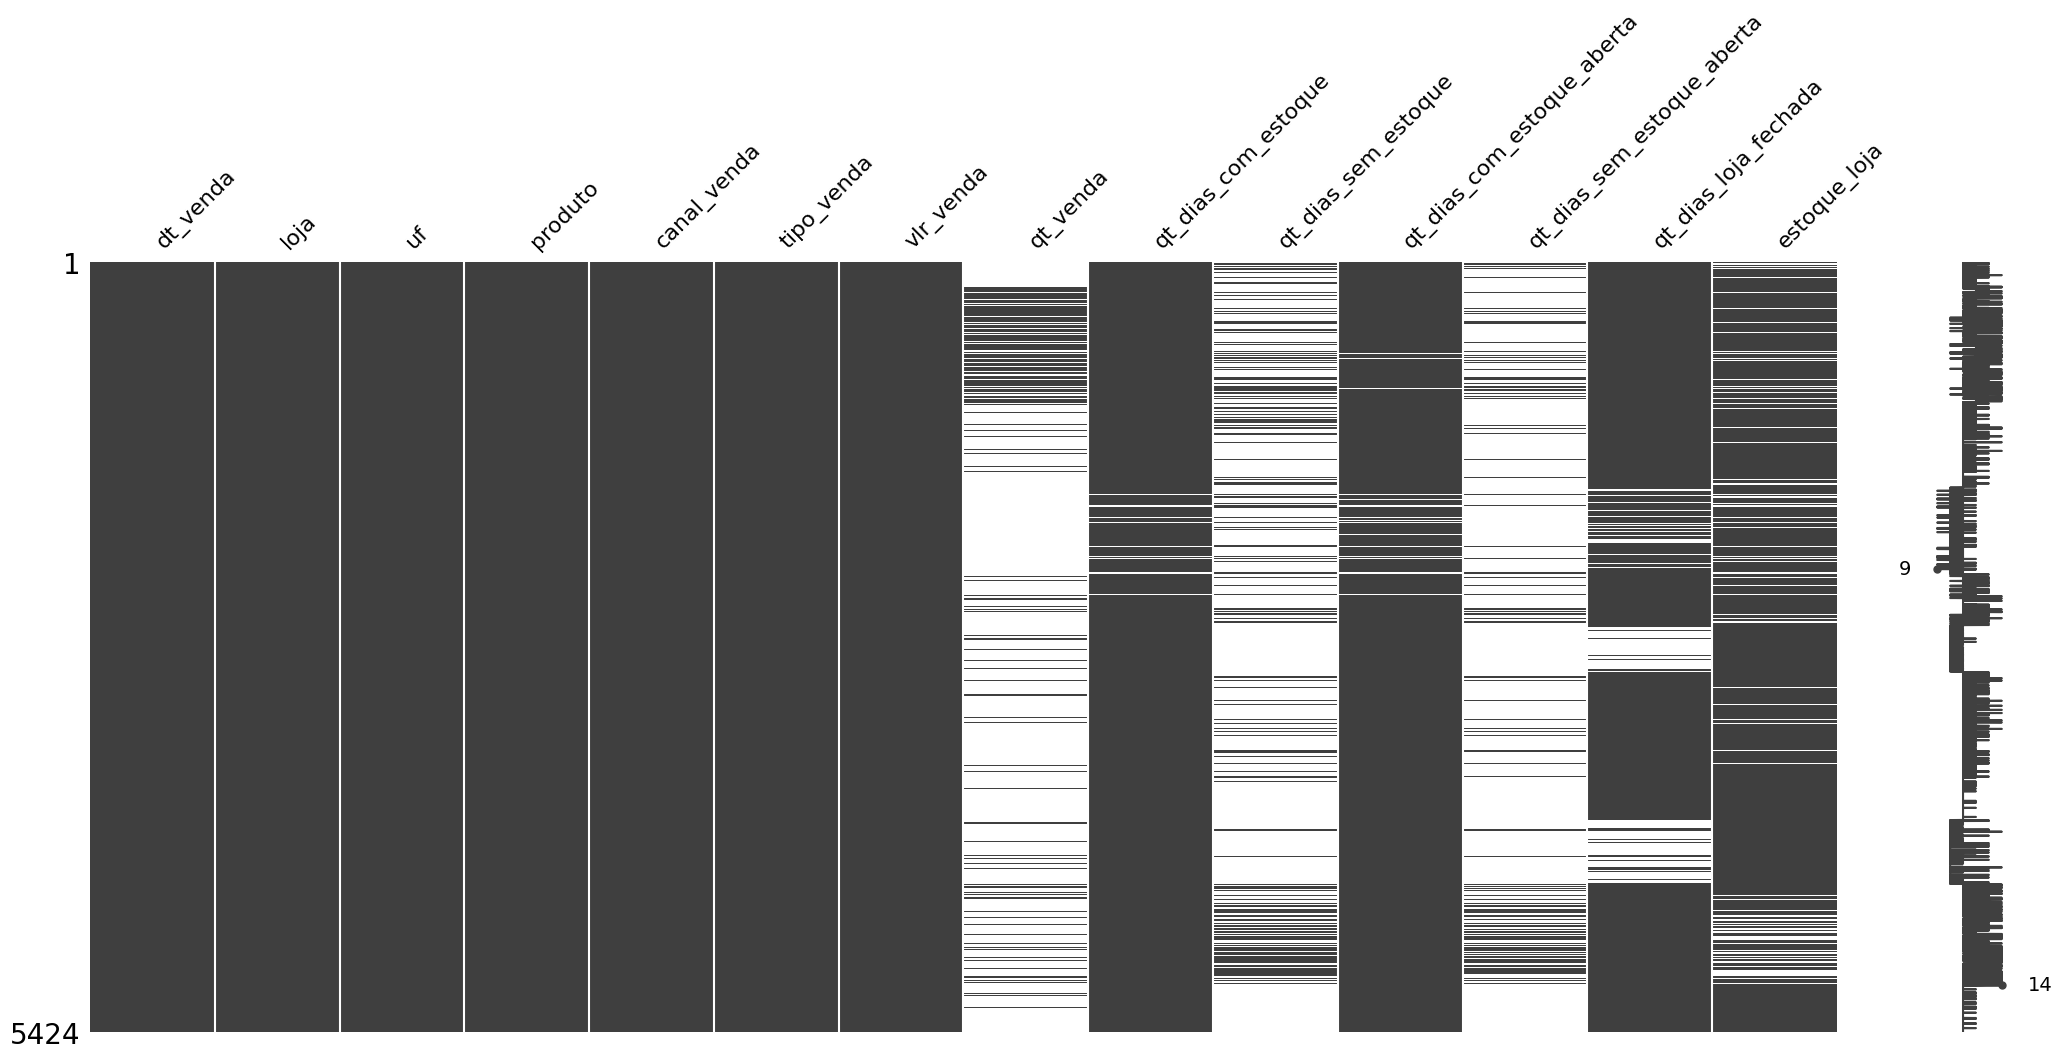

In [3]:
# salvando um novo dataset para tratamento de missings

# recuperando os nomes das colunas
col = list(dataset.columns)

# o novo dataset irá conter todas as colunas com exceção da última (classe)
atributos = dataset[col[0:-1]]

# substituindo os zeros por NaN
atributos.replace(0, np.nan, inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

<Axes: >

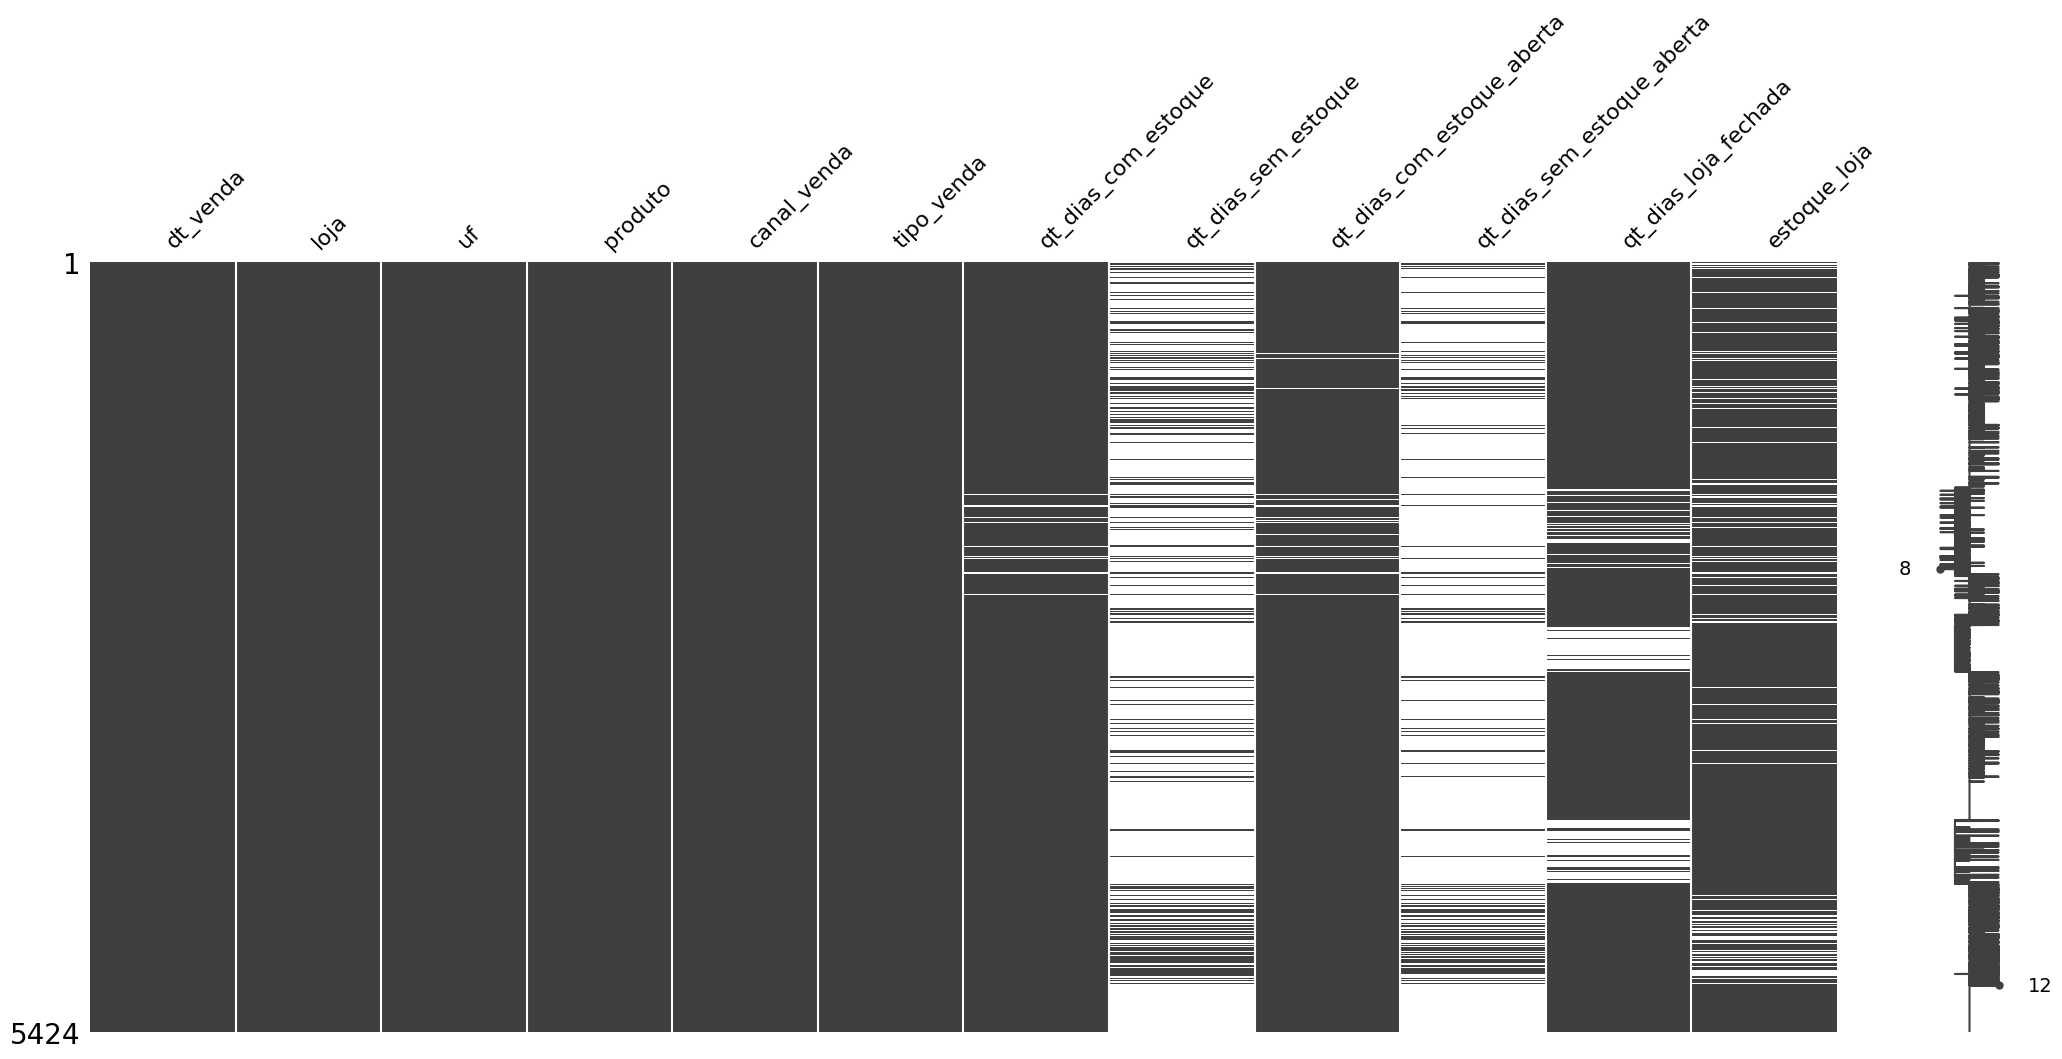

In [4]:
# removendo as colunas 'vlr_venda' e 'qt_venda'
atributos.drop(['vlr_venda', 'qt_venda'], axis=1, inplace= True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

<Axes: >

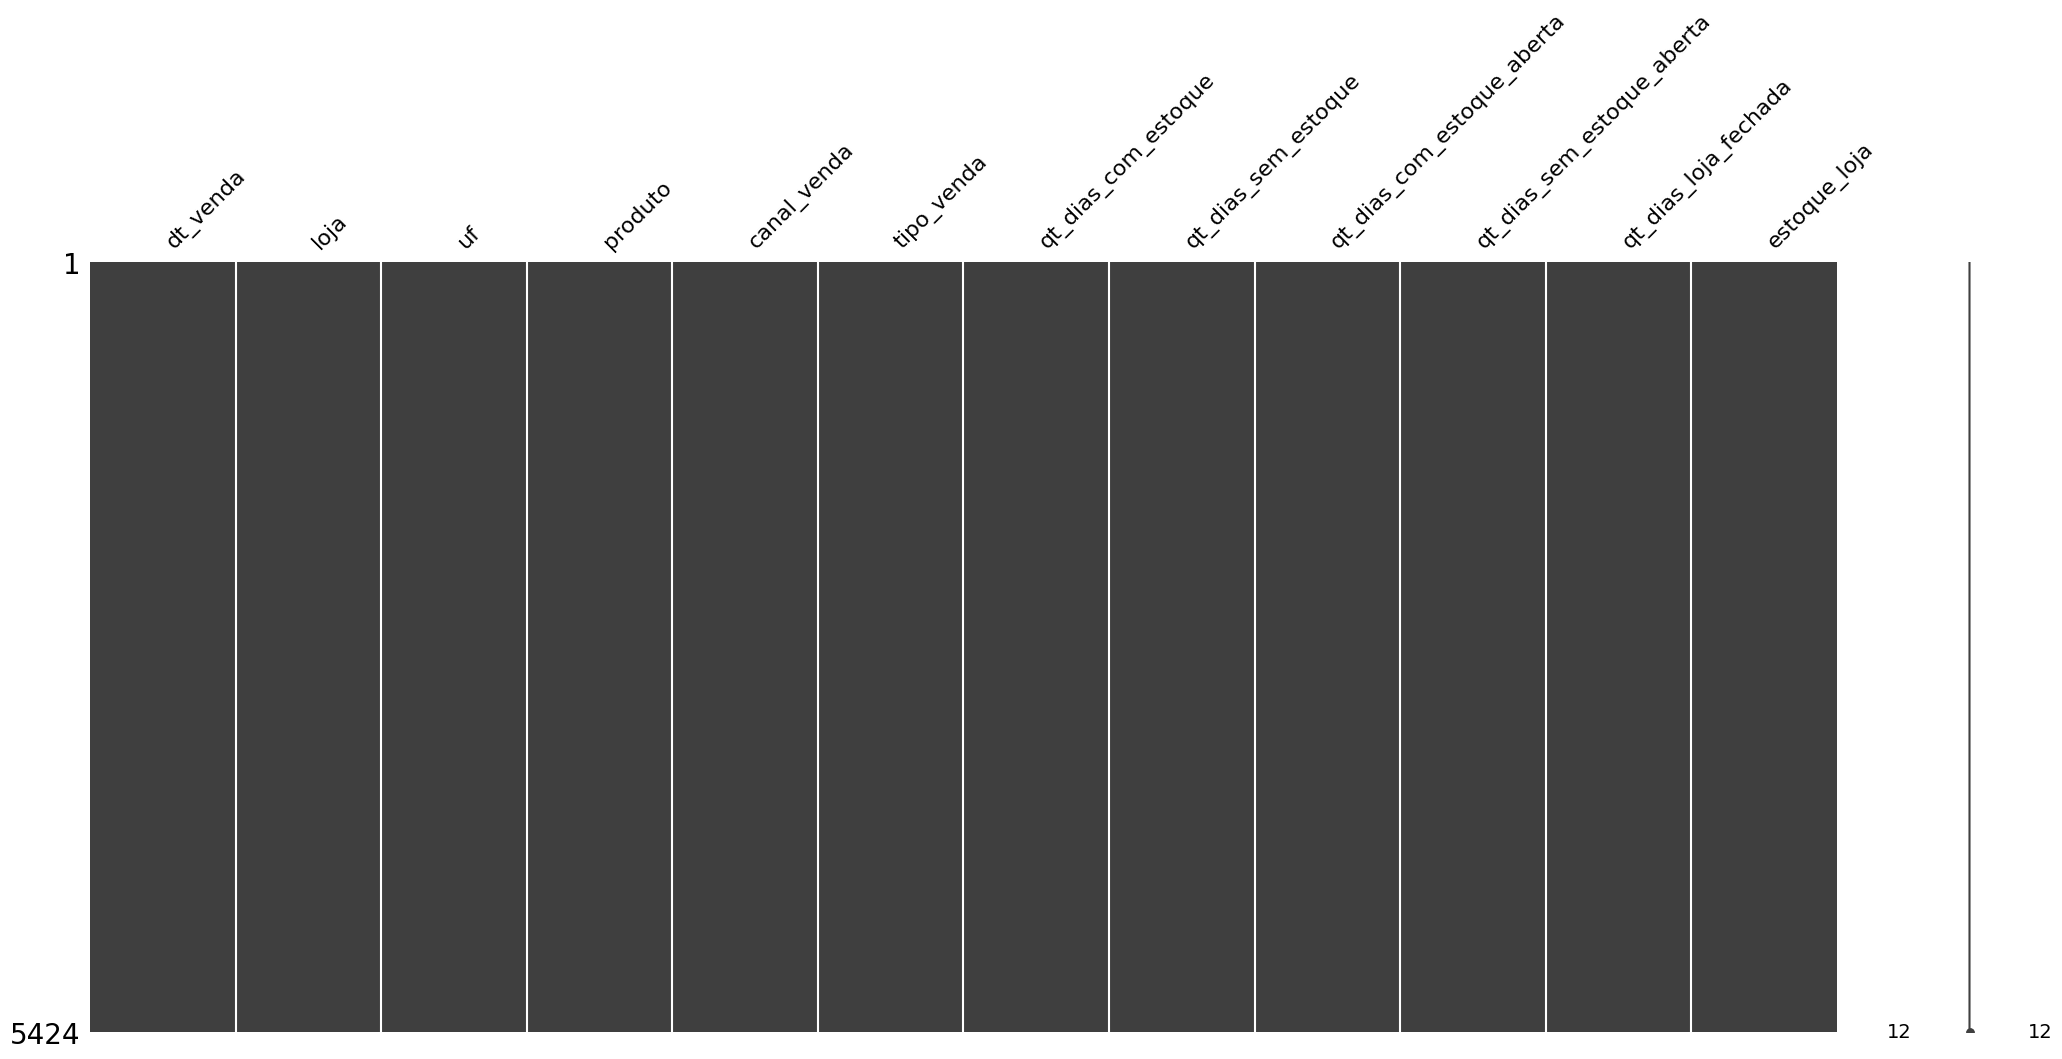

In [5]:
# substituindo os NaN por 0
atributos['qt_dias_sem_estoque'].fillna(0, inplace=True)
atributos['qt_dias_sem_estoque_aberta'].fillna(0, inplace=True)
atributos['estoque_loja'].fillna(0, inplace=True)

# substituindo os NaN de 'qt_dias_com_estoque' e 'qt_dias_com_estoque_aberta' pela mediana da coluna
atributos['qt_dias_com_estoque'].fillna(atributos['qt_dias_com_estoque'].median(), inplace=True)
atributos['qt_dias_com_estoque_aberta'].fillna(atributos['qt_dias_com_estoque_aberta'].median(), inplace=True)
atributos['qt_dias_loja_fechada'].fillna(atributos['qt_dias_loja_fechada'].median(), inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

In [12]:
# Guardando o novo dataset para testes futuros
datasetSemMissings = atributos

# incluindo a coluna 'class' no novo dataset
datasetSemMissings['habilitador'] = dataset['habilitador']

# exibindo as primeiras linhas
datasetSemMissings.head()

,dt_venda,loja,uf,produto,canal_venda,tipo_venda,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,estoque_loja,habilitador
0,2023-01-13,ABC13387,SP,Produto X,LOJA,PROMOCAO,2.0,26.0,2.0,4.0,22.0,0.0,1
1,2023-01-31,ABC12684,SP,Produto Z,LOJA,PROMOCAO,21.0,0.0,19.0,0.0,2.0,1.0,1
2,2023-01-01,ABC12684,SP,Produto Z,LOJA,PROMOCAO,28.0,0.0,27.0,0.0,1.0,4.0,1
3,2023-01-23,ABC12684,SP,Produto X,LOJA,PROMOCAO,21.0,0.0,19.0,0.0,2.0,3.0,1
4,2023-01-10,ABC12684,SP,Produto Z,LOJA,PROMOCAO,28.0,0.0,27.0,0.0,1.0,3.0,1


In [55]:
# Referenciando os atribuitos a uma nova variável
dataset_atributos = datasetSemMissings.loc[:, ['qt_dias_com_estoque', 'qt_dias_sem_estoque', 'qt_dias_com_estoque_aberta', 'qt_dias_sem_estoque_aberta', 'qt_dias_loja_fechada', 'habilitador']]
dataset_atributos.head()

,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,habilitador
0,2.0,26.0,2.0,4.0,22.0,1
1,21.0,0.0,19.0,0.0,2.0,1
2,28.0,0.0,27.0,0.0,1.0,1
3,21.0,0.0,19.0,0.0,2.0,1
4,28.0,0.0,27.0,0.0,1.0,1


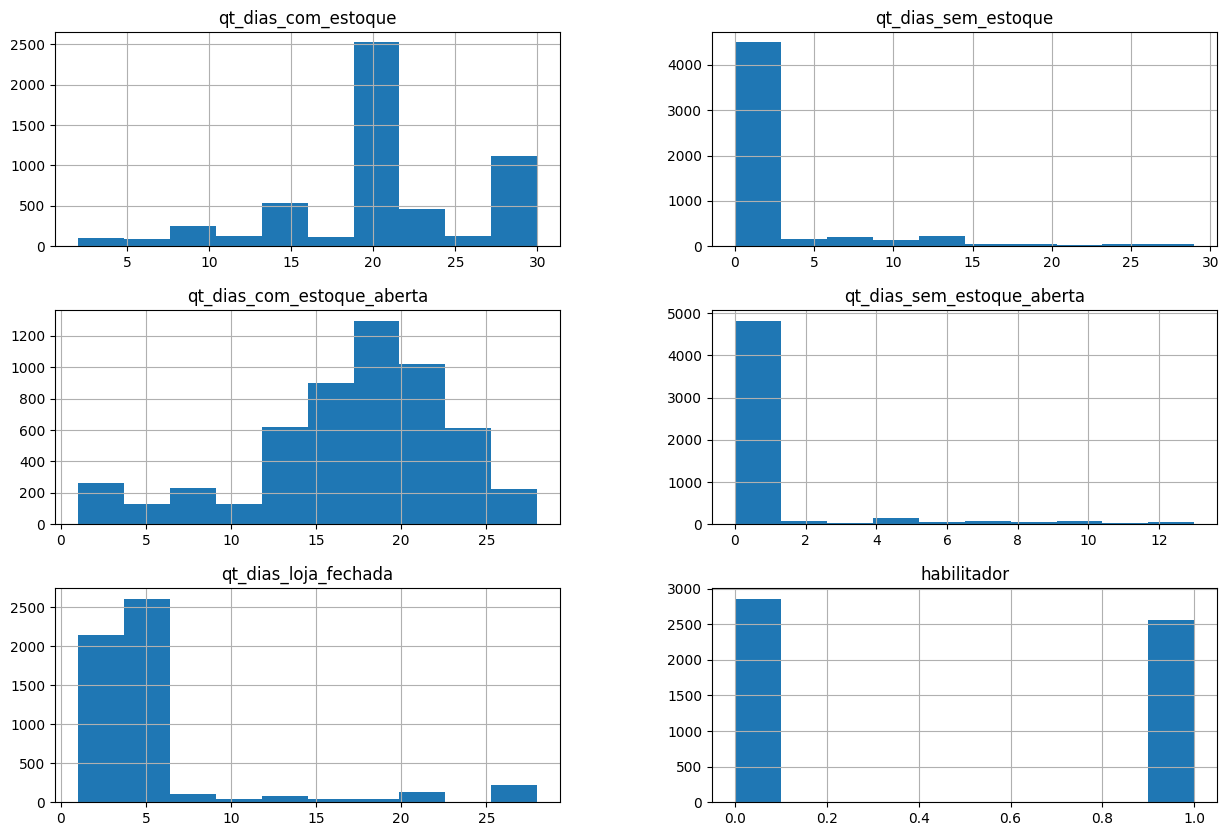

In [56]:
# Histograma
dataset_atributos.hist(figsize = (15,10))
plt.show()

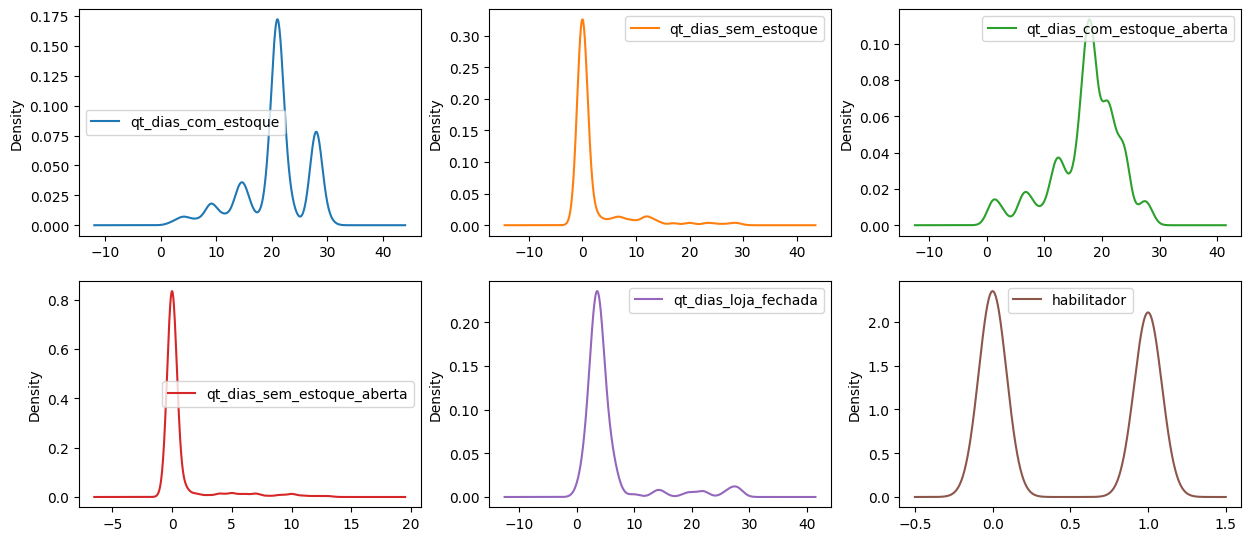

In [57]:
# Density Plot
dataset_atributos.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

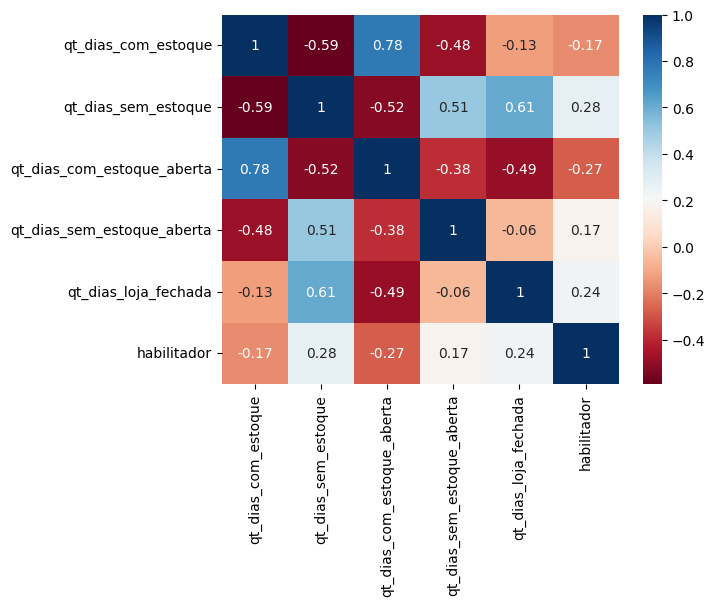

In [58]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(dataset_atributos.corr(), annot=True, cmap='RdBu');

** Feature Selection **

In [61]:
# Preparação dos dados para Feature Selection

# Separação em bases de treino e teste (holdout)
array = dataset_atributos.values
X = array[:,0:5] # atributos
y = array[:,5]   # classe (target)

In [63]:
# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=3)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset_atributos.columns[0:6])

# Exibe as pontuações de cada atributos e os 4 escolhidos (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset_atributos.columns[0:5]))


Número original de atributos: 5

Número reduzido de atributos: 3

Atributos Originais: Index(['qt_dias_com_estoque', 'qt_dias_sem_estoque',
       'qt_dias_com_estoque_aberta', 'qt_dias_sem_estoque_aberta',
       'qt_dias_loja_fechada', 'habilitador'],
      dtype='object')

Scores dos Atributos Originais: [170.06  452.718 441.478 170.279 321.486]

Atributos Selecionados: ['qt_dias_sem_estoque' 'qt_dias_com_estoque_aberta' 'qt_dias_loja_fechada']


In [65]:
# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=3)
fit = rfe.fit(X, y)

# Print dos resultados
print("Atributos Originais:", dataset_atributos.columns[0:6])

# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=dataset_atributos.columns[0:5]))

Atributos Originais: Index(['qt_dias_com_estoque', 'qt_dias_sem_estoque',
       'qt_dias_com_estoque_aberta', 'qt_dias_sem_estoque_aberta',
       'qt_dias_loja_fechada', 'habilitador'],
      dtype='object')

Atributos Selecionados: [ True  True  True False False]

Ranking de atributos: [1 1 1 2 3]

Qtd de melhores Atributos: 3

Nomes dos Atributos Selecionados: ['qt_dias_com_estoque' 'qt_dias_sem_estoque' 'qt_dias_com_estoque_aberta']


In [66]:
dataset_atributos.head()

,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,habilitador
0,2.0,26.0,2.0,4.0,22.0,1
1,21.0,0.0,19.0,0.0,2.0,1
2,28.0,0.0,27.0,0.0,1.0,1
3,21.0,0.0,19.0,0.0,2.0,1
4,28.0,0.0,27.0,0.0,1.0,1


In [68]:
# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset_atributos.columns[0:6])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)


Atributos Originais: Index(['qt_dias_com_estoque', 'qt_dias_sem_estoque',
       'qt_dias_com_estoque_aberta', 'qt_dias_sem_estoque_aberta',
       'qt_dias_loja_fechada', 'habilitador'],
      dtype='object')
[0.238 0.126 0.381 0.072 0.184]


Atributo com maior relevância durante as análises: **estoque_loja**

- SelectKBest: **698.377**
- ExtraTrees: **0.745**
- Recursiva: **True**

### **Passo 5: Separação em conjunto de Treino e Teste (Holdout)**

Nesta etapa foram realizados os seguintes processos:

- Validação cruzada
- Teste e comparação dos modelos

*Holdout sem estratificação*

In [32]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset_atributos.values
X = array[:,[1,2]]
y = array[:,5]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed) # holdout sem estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # Validação cruzada

*Holdout com estratificação*

In [69]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset_atributos.values
X = array[:,[1,2]]
y = array[:,5]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # Validação cruzada

In [70]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os módulos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 4
max_features = 2

# Criando os modelos para o VotingClassifier
bases = []
model1 = DecisionTreeClassifier()
bases.append(('cart', model1))
model2 = SVC()
bases.append(('svm', model2))

In [71]:
# Criando os ensembles e adicionando-os na lista de modelos
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))

In [72]:
# Lista para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

CART: 0.723200 (0.021741)
SVM: 0.630786 (0.017767)
RF: 0.723891 (0.029982)
ET: 0.723200 (0.021741)
GB: 0.656366 (0.017241)


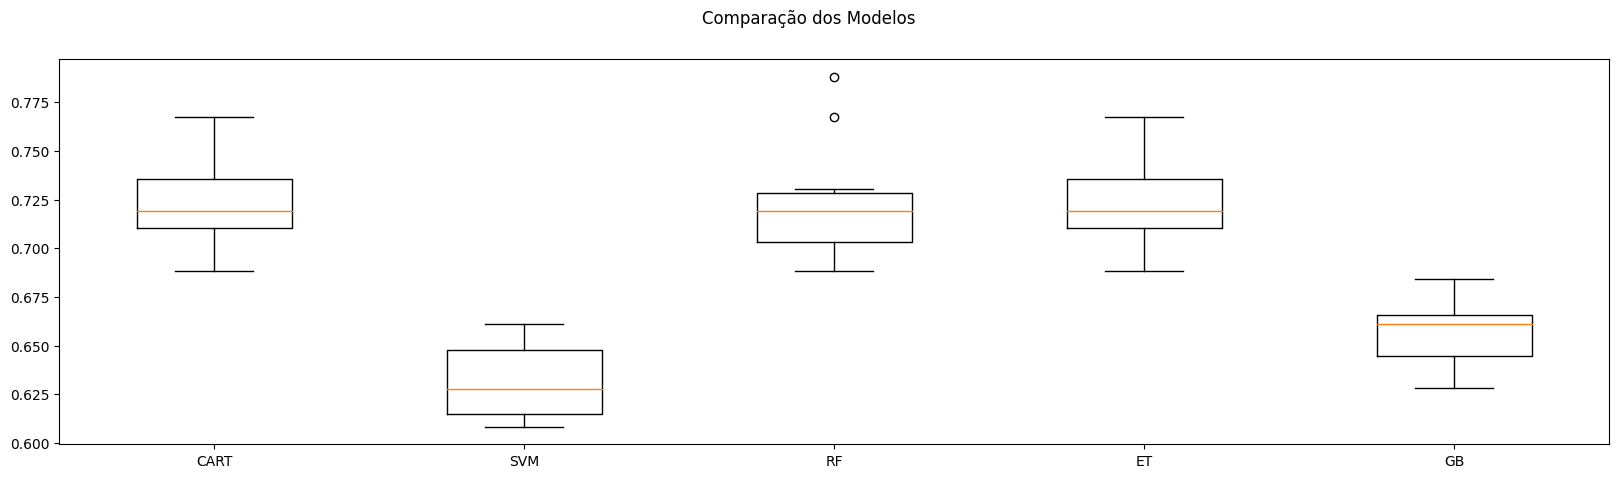

In [74]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(20,5))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### **Passo 6: Pipeline**

Nesta etapa foi feita a comparação entre os modelos:

- Original
- Padronizado
- Normalizado

In [79]:
np.random.seed(7) # definindo uma semente global para este bloco

# Lista para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

#Algoritmos que serão utilizados
#cart = ('CART', DecisionTreeClassifier())
#svm = ('SVM', SVC())
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
#extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
#gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

In [80]:
#Montando os pipelines

# Dataset original
#pipelines.append(('CART-orig', Pipeline([cart])))
#pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
#pipelines.append(('ET-orig', Pipeline([extra_trees])))
#pipelines.append(('GB-orig', Pipeline([gradient_boosting])))

# Dataset padronizado
#pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
#pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
#pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
#pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))

# Dataset normalizado
#pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
#pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
#pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
#pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))

# Executando os pipelines
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

RF-orig: 0.729 (0.027)
RF-padr: 0.723 (0.022)
RF-norm: 0.726 (0.023)


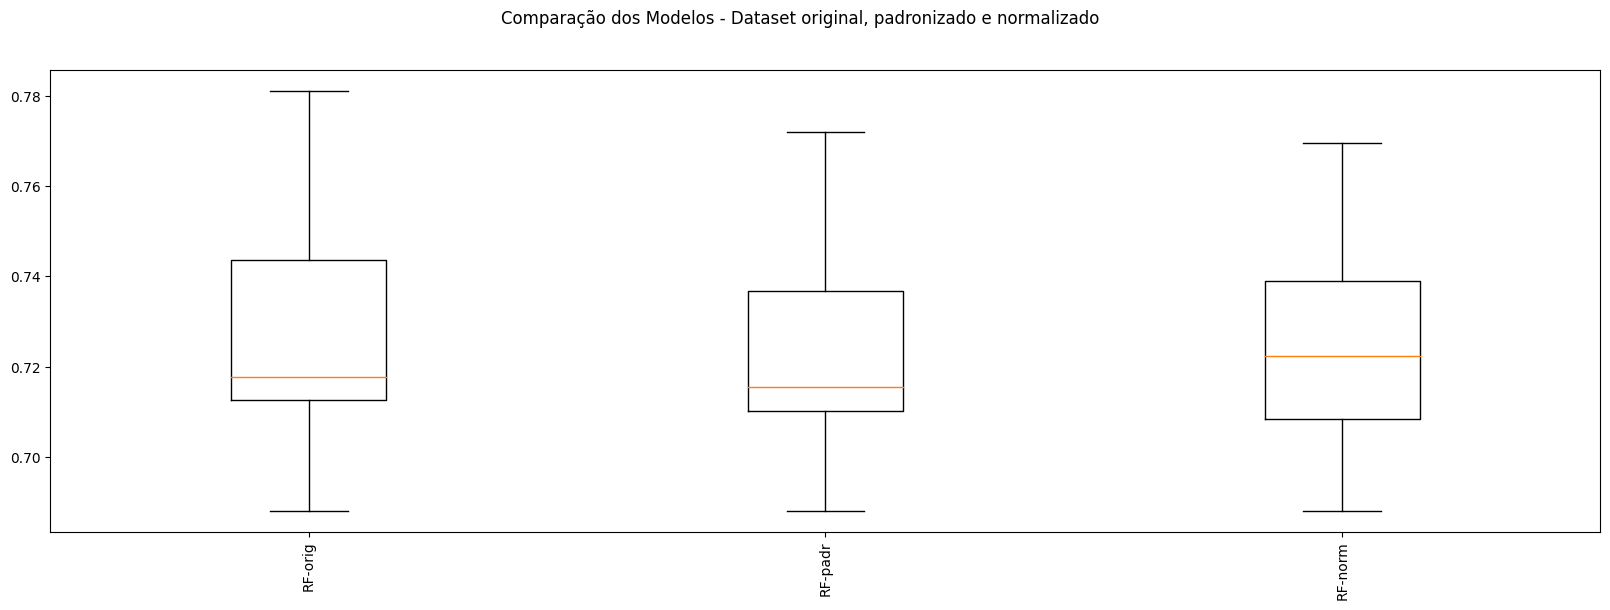

In [81]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(20,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### **Passo 7: Avaliação do modelo**

Nesta etapa foi realizado a avaliação do modelo em conjunto de teste

In [83]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.7299539170506912


### **Passo 8: Aplicação em produção**

Nesta etapa, após a escolha do modelo, foi realizado o uso do mesmo com novos dados

In [84]:
# Preparação do modelo com todo o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com todo o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com todo o dataset
model.fit(rescaledX, y)

RandomForestClassifier(max_features=2, n_estimators=4)

In [86]:
dataset_atributos.head()

,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,habilitador
0,2.0,26.0,2.0,4.0,22.0,1
1,21.0,0.0,19.0,0.0,2.0,1
2,28.0,0.0,27.0,0.0,1.0,1
3,21.0,0.0,19.0,0.0,2.0,1
4,28.0,0.0,27.0,0.0,1.0,1


In [90]:
print(entrada)

   qt_dias_sem_estoque  qt_dias_com_estoque_aberta
0                    3                           2
1                    5                          20
2                   15                          10


In [93]:
# Simulação com novos dados

data = {
        'qt_dias_sem_estoque': [3, 5, 0],
        'qt_dias_com_estoque_aberta': [7, 28, 10],
        }

atributos = ['qt_dias_sem_estoque', 'qt_dias_com_estoque_aberta']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:2].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 0.156 -1.723]
 [ 0.525  1.855]
 [-0.397 -1.212]]


In [94]:
# Predição de classes dos dados de entrada

saidas = model.predict(rescaledEntradaX)
print(saidas)

[1. 0. 1.]


### **Conclusão**

- O modelo que apresentou melhor resultado foi o SVM, com 57,88%;
- Ao realizar os primeiros testes, verificou-se que os modelos RandomForest e GradientBoosting apresentaram overfitting durante os testes...